# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [35]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [37]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [38]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Define a dataset and data loader

In [39]:
class SingleFolderImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: 
            img = self.transform(img)
        return img, path   # return image and path

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

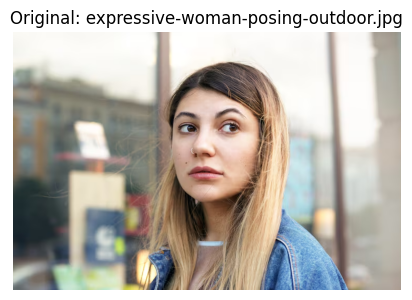

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98828125..0.99609375].


Face detected in expressive-woman-posing-outdoor.jpg with probability: 0.999999


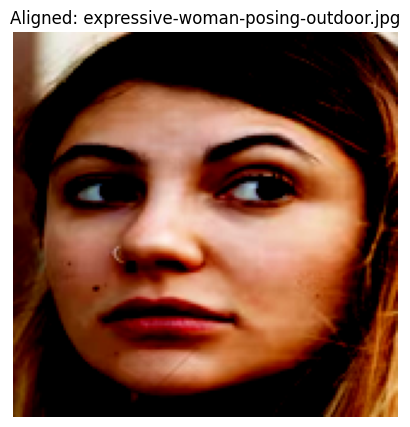

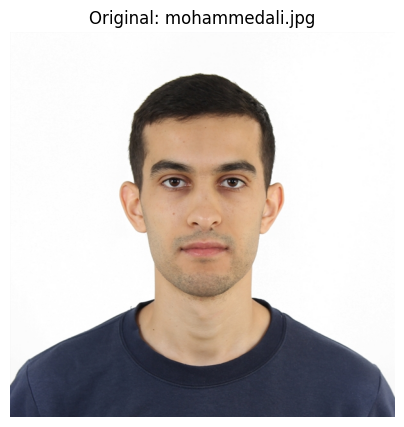

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88671875..0.99609375].


Face detected in mohammedali.jpg with probability: 0.999233


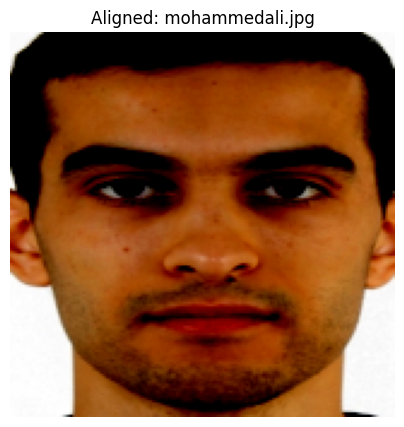

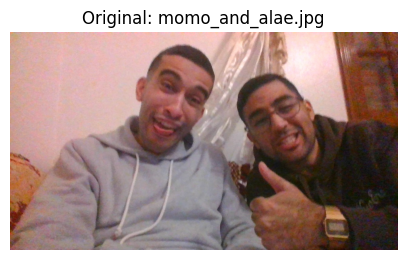

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85546875..0.97265625].


Face detected in momo_and_alae.jpg with probability: 0.999992


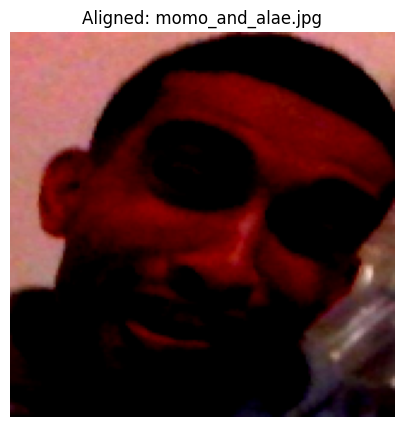

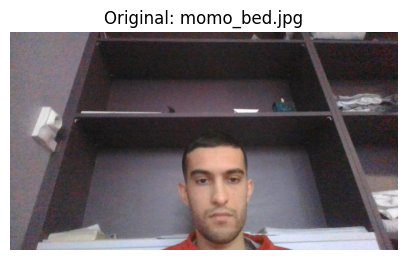

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91015625..0.96484375].


Face detected in momo_bed.jpg with probability: 0.999989


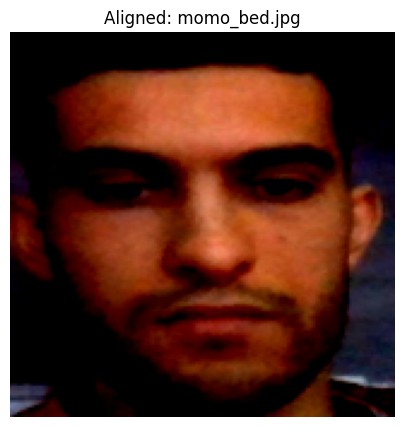

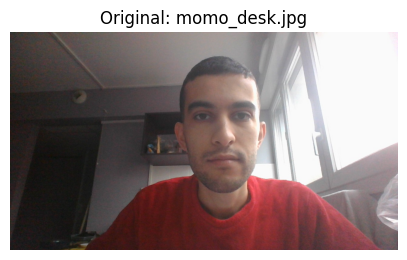

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78515625..0.99609375].


Face detected in momo_desk.jpg with probability: 0.999977


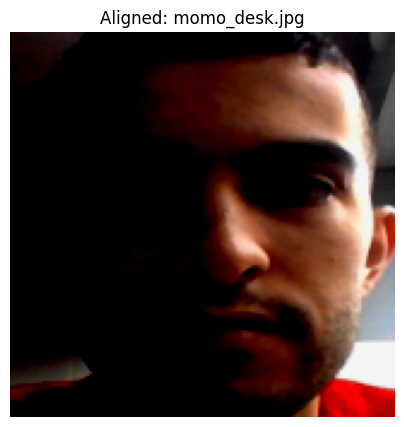

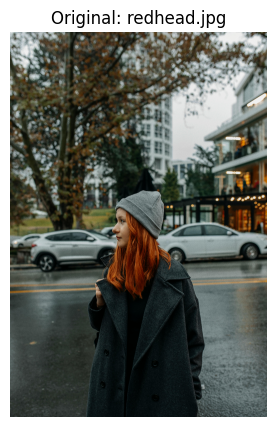

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99609375..0.66796875].


Face detected in redhead.jpg with probability: 0.999588


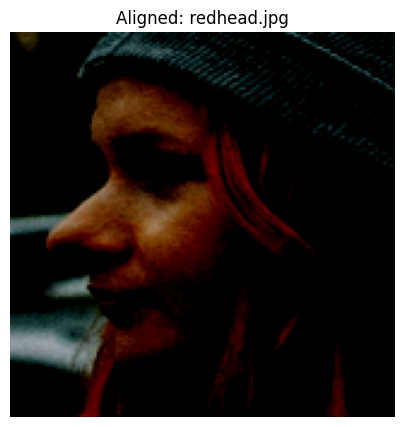

In [43]:
dataset = SingleFolderImageDataset('../assets/reference_faces')
loader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: x[0])

mtcnn = MTCNN(image_size=160, margin=14, post_process=True)

aligned_images = []
image_names = []

# -----------------------------
# Processing + Visualization
# -----------------------------
for img, path in loader:
    filename = os.path.basename(path)

    # ---- Show original image ----
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Original: {filename}")
    plt.axis("off")
    plt.show()

    # MTCNN alignment
    x_aligned, prob = mtcnn(img, return_prob=True)

    if x_aligned is not None:
        print(f"Face detected in {filename} with probability: {prob:.6f}")

        aligned_images.append(x_aligned)
        image_names.append(filename)

        # ---- Show aligned image ----
        aligned_img = x_aligned.permute(1, 2, 0).detach().cpu().numpy()

        plt.figure(figsize=(5, 5))
        plt.imshow(aligned_img)
        plt.title(f"Aligned: {filename}")
        plt.axis("off")
        plt.show()

    else:
        print(f"No face detected in {filename}")


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [44]:
aligned = torch.stack(aligned_images).to(device)
embeddings = resnet(aligned).detach().cpu()

In [47]:
print(embeddings.shape)

torch.Size([6, 512])


#### Print distance matrix for classes

In [45]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]

from tabulate import tabulate
df = pd.DataFrame(dists, columns=image_names, index=image_names)
print(tabulate(df, headers='keys', tablefmt='psql'))


+-------------------------------------+---------------------------------------+-------------------+---------------------+----------------+-----------------+---------------+
|                                     |   expressive-woman-posing-outdoor.jpg |   mohammedali.jpg |   momo_and_alae.jpg |   momo_bed.jpg |   momo_desk.jpg |   redhead.jpg |
|-------------------------------------+---------------------------------------+-------------------+---------------------+----------------+-----------------+---------------|
| expressive-woman-posing-outdoor.jpg |                               0       |          1.46479  |            1.37442  |       1.32821  |        1.35279  |       1.39957 |
| mohammedali.jpg                     |                               1.46479 |          0        |            0.873476 |       0.662383 |        0.640261 |       1.39154 |
| momo_and_alae.jpg                   |                               1.37442 |          0.873476 |            0        |       0.74760